In [ ]:
import sys
import os
import pandas as pd

from bokeh.palettes import Category10


from file_cache.utils.util_pandas import *
from file_cache.cache import file_cache

import matplotlib.pyplot as plt

#Adjust the working folder
file_folder = globals()['_dh'][0]
wk_dir = os.path.dirname(file_folder)
os.chdir(wk_dir)
from core.feature import *
from core.train import *
logging.getLogger().setLevel(logging.DEBUG)

import argparse
sys.argv = ['program',  '--file_num',  '0', '--cut_len', '200', '--top_threshold', '0.5']

args = options()
args


In [ ]:
df = pd.read_hdf('./cache/check_score_all==pic=False.h5')
col_list = [item for item in df.columns if '_file_' in item]
df['gap'] = df[col_list].max(axis=1) - df.iloc[:, -5:].min(axis=1)

df['best'] = df[col_list].idxmax(axis=1).apply(lambda val: val.split('_')[1])
col = 'var018'
df.sort_values('gap')#.loc[col:col]

In [ ]:

for col in get_predict_col(): 
    score_df = check_score_all(pic=False)  # .reset_index()

    col_name=col

    ser = score_df.iloc[:, -5:].idxmax(axis=1)
    #print(ser.loc[col_name])
    logger.debug(ser)
    print(int(ser.loc[col_name].split('_')[1]))

In [ ]:
tmp1 = get_train_ex(1)
tmp1.var034.plot()

tmp1 = get_train_ex(2)
tmp1.var034.plot()


In [ ]:
train

In [ ]:
score_df = check_score_all(version='0126')#.reset_index()  
score_df
score_df.iloc[:, -5:].idxmax(axis=1).sort_values()

In [ ]:

for wtid in range(1,2):
    group_list = group_columns(wtid=1)
    for group in group_list:
        logger.debug(f'Current group:{group}')
        train = get_train_ex(wtid)
        train = train[group]   
        logger.debug(f'Old len = {len(train)}')
        train = train.dropna(how='all')
        logger.debug(f'New len = {len(train)}')
        print(len(train), train.where(pd.isna(train), 1).sum())

    

In [ ]:
logging.getLogger().setLevel(logging.WARNING)
train_list = []
from tqdm import tqdm
for wtid in tqdm(range(1, 3)):
    train_ex =  predict_wtid(wtid)
    train_ex = train_ex.set_index(['ts', 'wtid'])
    train_list.append(train_ex)
submit = pd.concat(train_list)

In [ ]:
get_closed_columns('var034')

In [ ]:
score_df.score.mean()


## Validate  Score
 

In [ ]:
 

#check_score(col, pic=True)
score_df = check_score_all(False)

score_df

## Analysis the std of the column

In [ ]:
std = get_std_all()
std = std.groupby(['col', 'data_type']).agg({'mean': ['mean', 'min', 'max', 'std']})   

std = std.reset_index().set_index('col')
std


## get corr between wtid for special col

In [ ]:
get_corr_wtid('var034')

## Get corrcoef matrix within wtid

In [ ]:
sub = get_train_ex(1)

sub = sub.dropna(how='any')

cor = np.corrcoef(sub.drop(axis='column', columns=['ts','wtid']).T)

col_list = sub.columns[2:]

print(cor.shape, sub.shape)

cor1 = pd.DataFrame(index=col_list, columns=col_list, data=np.where(abs(cor)>0, cor, 0) )

cor1 

## Visual missing block

In [ ]:
import matplotlib.pyplot as plt
for wtid in range(1, 5):
    block_list = get_blocks()
    block_list = block_list.loc[(block_list.wtid==wtid) &(block_list.kind=='missing') ]
    block_list

    plt.figure(figsize=(20,10))


    for col_name in block_list.col.drop_duplicates().sort_values().values:
        #print(col_name)
        block_sub = block_list.loc[block_list['col'] == col_name]

        for index, block in block_sub.iterrows():
            sn = int(block['col'][-3:])
            plt.plot([block.begin, block.end], [sn, sn], color=Category10[10][sn%10] )


plt.show()

## Visual missing block(For special col)

In [ ]:
import matplotlib.pyplot as plt
block = adjust_block(ratio = 1)
col_name = 'var011'
for wtid in range(1, 5):
    block_list = adjust_block()
    block_list = block_list.loc[(block_list.wtid==wtid) &(block_list.kind=='missing') ]
    block_list

    plt.figure(figsize=(20,3))

    count = 0

    for col_name in get_closed_columns(col_name,threshold=0.8):
        #print(col_name)
        block_sub = block_list.loc[block_list['col'] == col_name].reset_index()
        
        count += 1
        for index, block in block_sub.iterrows():
            #sn = int(block['col'][-3:])
            plt.plot([block.begin_ex, block.end_ex], [count, count], color=Category10[10][index%10] )

plt.show()



In [ ]:

block2 = block[(block.wtid < 5) &(block.col=='var003') & (block.kind=='missing')]
block2.end_ex.max(), block2.end.max()
#block.loc[(block.wtid==1) &(block.col=='var001')&(block.kind=='missing')]




## Main

In [ ]:
block_list = get_blocks()
for wtid in range(1, 2):
    train_ex = get_train_ex(wtid)
    for blockid, missing_block in block_list.loc[(block_list.wtid == wtid) & (block_list.kind == 'missing')].iterrows():
        col_name = missing_block.col
        train, sub = get_submit_feature_by_block_id(blockid)
        logger.info(f'blockid:{blockid}, train:{train.shape}')
        predict_fn = get_predict_fun(blockid, train)
        predict_res = predict_fn(sub.time_sn)
        sub[col_name] = predict_res
        logger.debug(f'predict_res:{predict_res.shape}, {type(predict_res)}')
        begin, end = missing_block.begin, missing_block.end

        logger.debug(f'train.loc[begin:end,col_name] = {train_ex.loc[begin:end,col_name].shape}, {begin}, {end}, {wtid}, {col_name}')
        train_ex.loc[begin:end,col_name] = predict_res
        
train_ex

## VIsual predict result

Namespace(cut_len=600, debug=False, file_num=5, top_threshold=0.5, version='0129', window=0.7)


2019-01-31 00:11:50,235 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14019, 3316:6565, time_sn:24432.386:48377.006 (1896, 6), (1354, 6), score=0.85,
2019-01-31 00:11:50,279 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14021, 23516:26765, time_sn:173279.196:197215.557 (1896, 6), (1354, 6), score=0.873,
2019-01-31 00:11:50,325 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14023, 40227:43476, time_sn:296418.074:320354.771 (1896, 6), (1354, 6), score=0.978,
2019-01-31 00:11:50,370 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14025, 53829:57078, time_sn:396642.513:420586.081 (1896, 6), (1354, 6), score=0.935,
2019-01-31 00:11:50,415 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14027, 79803:83052, time_sn:588089.575:612049.483 (1896, 6), (1354, 6), score=0.945,
2019-01-31 00:11:50,463 <ipython-input-30-7bd2dd722590>[91] INFO blockid:14031, 99725:102974, time_sn:734928.295:758865.222 (1896, 6), (1354, 6), score=0.883,
2019-01-31 00:11:50,508 <ipython-input-30-7bd2dd722590>[

Total loss====:0.9044, is_enum:False, file_num:5, time_enable:False


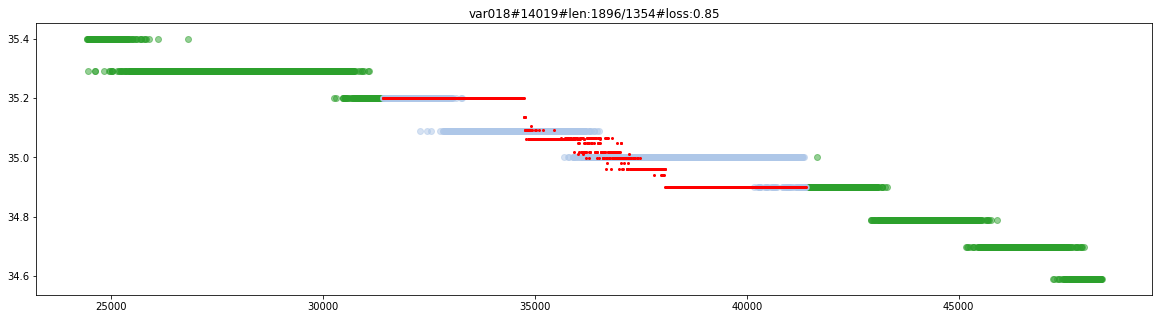

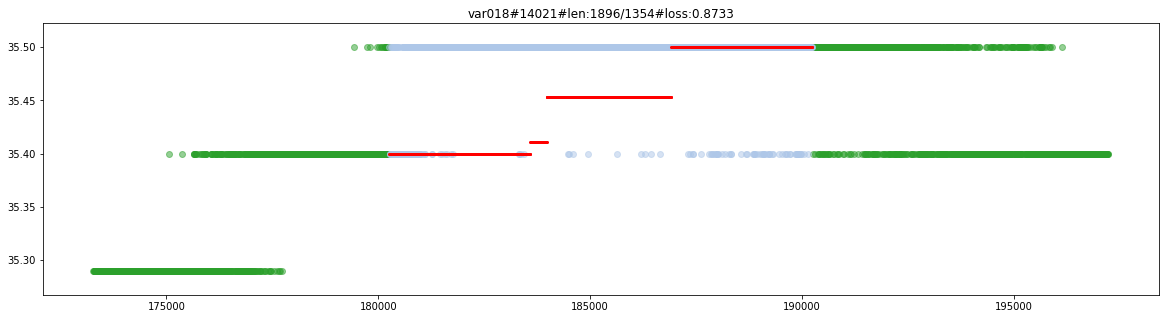

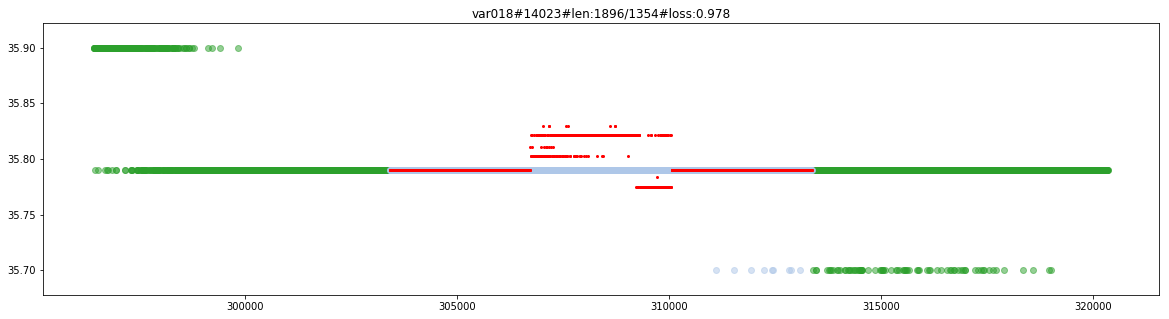

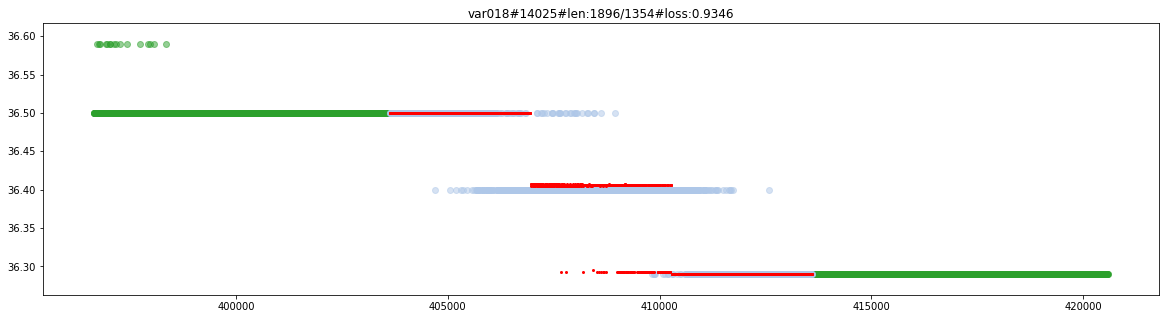

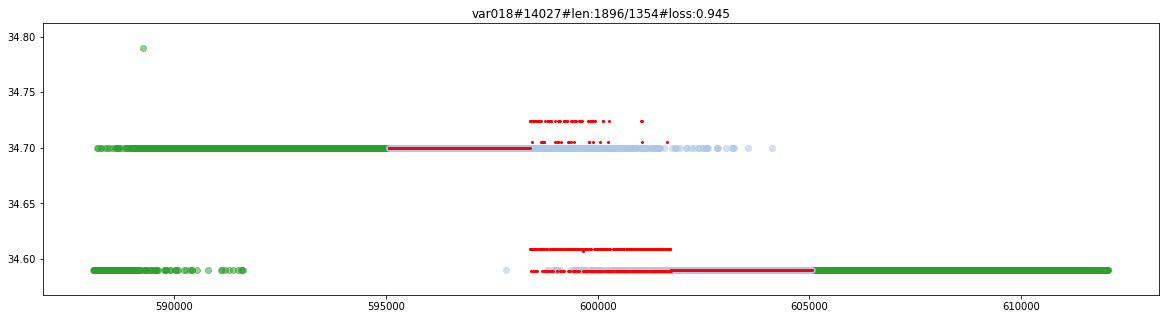

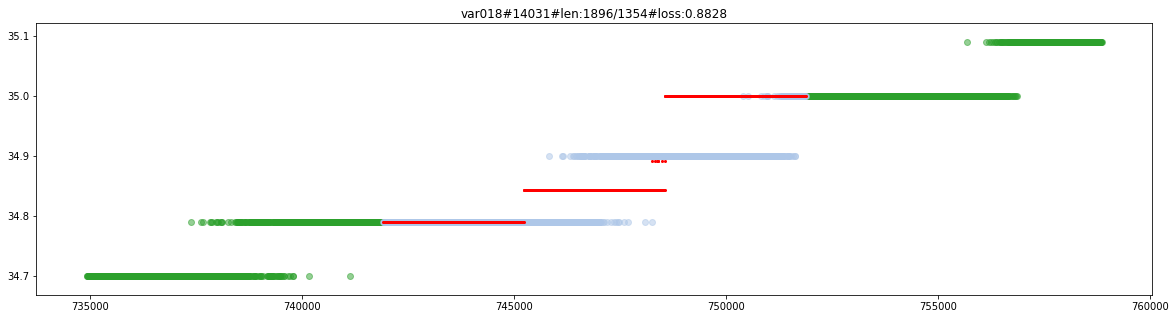

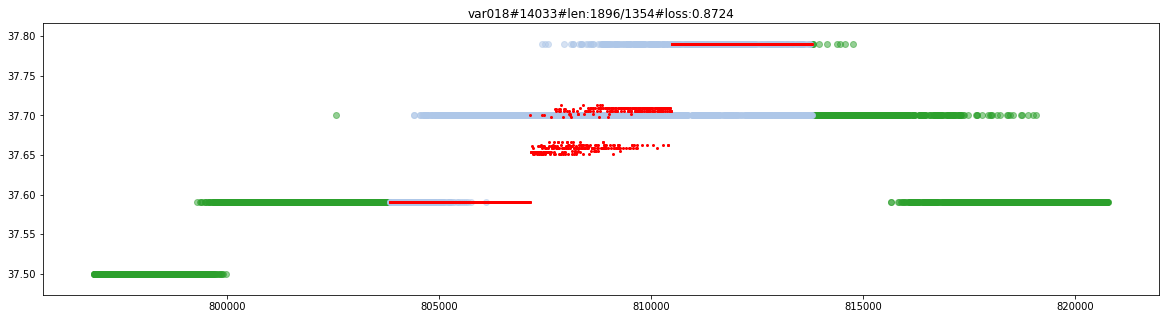

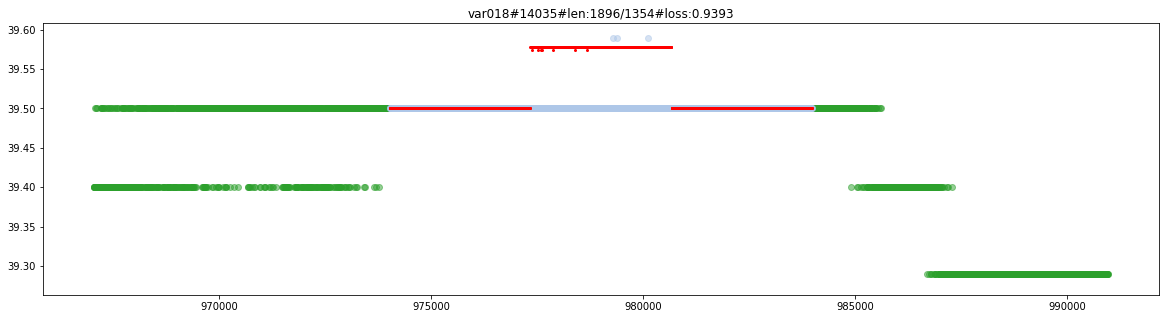

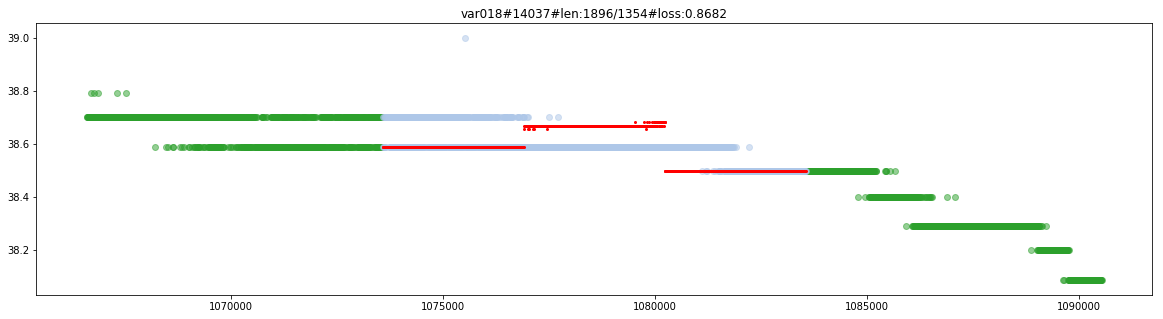

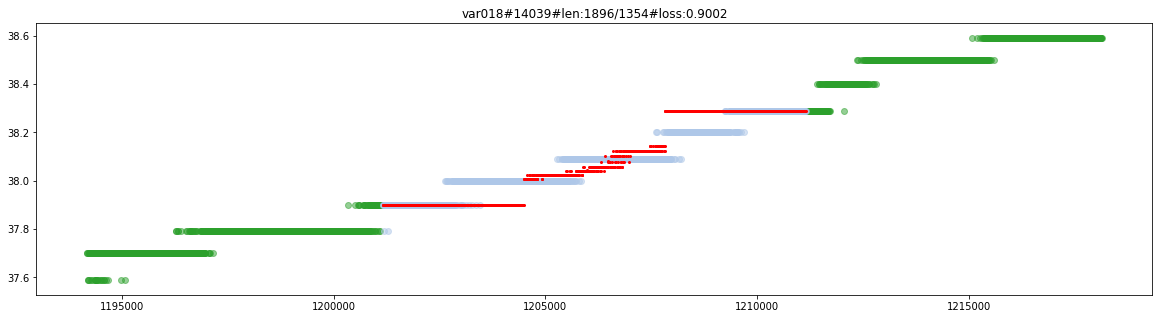

In [30]:

import sys
import os
import pandas as pd

from bokeh.palettes import Category10


from file_cache.utils.util_pandas import *
from file_cache.cache import file_cache

import matplotlib.pyplot as plt

#Adjust the working folder
file_folder = globals()['_dh'][0]
wk_dir = os.path.dirname(file_folder)
os.chdir(wk_dir)
from core.feature import *
from core.train import *

import matplotlib.pyplot as plt

sys.argv = ['program',  '--file_num',  '5', '--cut_len', '600', '--top_threshold', '0.5', '--window', '0.7' ]
args = options()
args
print(args)
    
    
time_enable = False
col =  'var031' #'var018'
col =  'var018' #'var018'
#col =  'var067'
train_list = get_train_feature(5, col, args )

train_list = sorted(train_list, key=lambda val: len(val[1]), reverse=True)

count, loss = 0, 0
for train, val, blockid in train_list[:10]:
    plt.figure(figsize=(20,5))
    

    is_enum = True if 'int' in date_type[col].__name__ else False
    
#     if is_enum:
#         fn = lambda val:  np.full_like(val,train[col].value_counts().index[0])
#     else:    
#         w = np.polyfit (train.time_sn, train[col], 1)
#         fn = np.poly1d(w)
    if  time_enable or args.file_num==1 :
        train_bk = train 
        val_bk = val 
        
    else:
        train_bk = train.drop(axis='column', columns=['time_sn'])
        val_bk = val.drop(axis='column', columns=['time_sn'])
#         if args.file_num>1 :
#             train_bk.plot()
            

        
    #print('shape',train_bk.shape, val_bk.shape, val_bk.columns, train_bk.index.min(),train_bk.index.max())
    fn = get_predict_fun(blockid,train_bk, args)
    cur_count, cur_loss = score(val[col], fn(val_bk.iloc[:, 1:]), is_enum)
    
    #print(cur_loss, cur_count)                            
    loss  += cur_loss 
    count += cur_count 
    
    plt.title(f'{col}#{blockid}#len:{len(train)}/{len(val)}#loss:{round(cur_loss/cur_count, 4)}')
    
    #Original Point
    for color, data in zip(['#2ca02c','#aec7e8'], [train, val]):
        plt.scatter(data.time_sn, data[col], c= color, alpha=0.5)
        
    #Predict point    
    plt.scatter(val.time_sn, fn(val_bk.iloc[:, 1:]), c='red', s=4)
    
    
    if args.file_num==1:
        x = np.linspace(train.time_sn.min(), train.time_sn.max(), 100)
        plt.plot(x, fn(np.expand_dims(x, axis=1))) 
    
    
    
    #print(val[col].shape, val.iloc[:, 1:].shape)
    
    
    


    logger.info(f'blockid:{blockid}, {train.index.min()}:{train.index.max()}, time_sn:{train.time_sn.min()}:{train.time_sn.max()} {train.shape}, {val.shape}, score={round(cur_loss/cur_count,3)},')
print(f'Total loss====:{round(loss/count, 4)}, is_enum:{is_enum}, file_num:{args.file_num}, time_enable:{time_enable}')




In [15]:
plt.show()

In [ ]:
s = score(val[col], (fn(val_bk.iloc[:, 1:]) + val_bk.iloc[:, 1])/2, is_enum)
print(s[1]/s[0])

s = score(val[col], fn(val_bk.iloc[:, 1:])  , is_enum)
print(s[1]/s[0])

s = score(val[col],   val_bk.iloc[:, 1], is_enum)
print(s[1]/s[0])


In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
n_samples, n_features = 10, 5
np.random.seed(0)
y = np.random.randn(n_samples)
X = np.random.randn(n_samples, 1)
print(X.shape)
print(y.shape)
clf = Ridge(alpha=1.0)
clf.fit(X, y) 

## Visual submit data

In [ ]:
import matplotlib.pyplot as plt

block = get_blocks() 
wtid = 1
col = 'var001'
missing_block = block.loc[(block.wtid == wtid) & (block.col == col) & (block.kind == 'missing')]
missing_block
for blockid, row in missing_block[:5].iterrows():
    train, sub = get_submit_feature_by_block_id(blockid)
    logger.info(f'blockid:{blockid}, train:{train.shape}')
    predict_fn = get_predict_fun(blockid, train)
    predict_res = predict_fn(sub.time_sn)
    sub[col] = predict_res
    
    for color, data in zip(Category10[5][:2], [train, sub]):
        plt.scatter(data.time_sn, data[col], c= color)
    
    x = np.linspace(train.time_sn.min(), train.time_sn.max(), 10000)
    
    is_enum = True if 'int' in date_type[col].__name__ else False
    cur_count, cur_loss = score(sub[col], predict_fn(sub.time_sn), is_enum)
    
    
    plt.plot(x, predict_fn(x))    
#     plt.plot(x, np.full_like(x, train[col].mean()) , c='r')  
    plt.show()

## Visual the specific train_feature accross file

Index(['var067', 'var067_8', 'var067_9', 'var067_20', 'var067_2', 'time_sn'], dtype='object')
588089.575 612042.117


/apps/dslab/anaconda/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


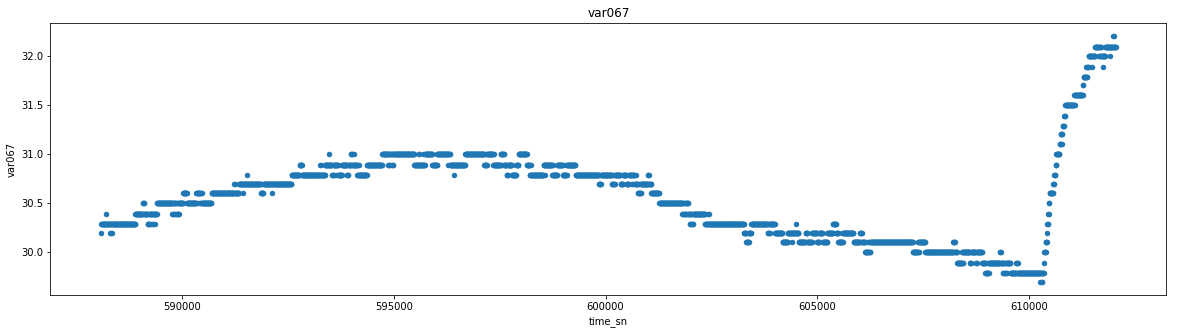

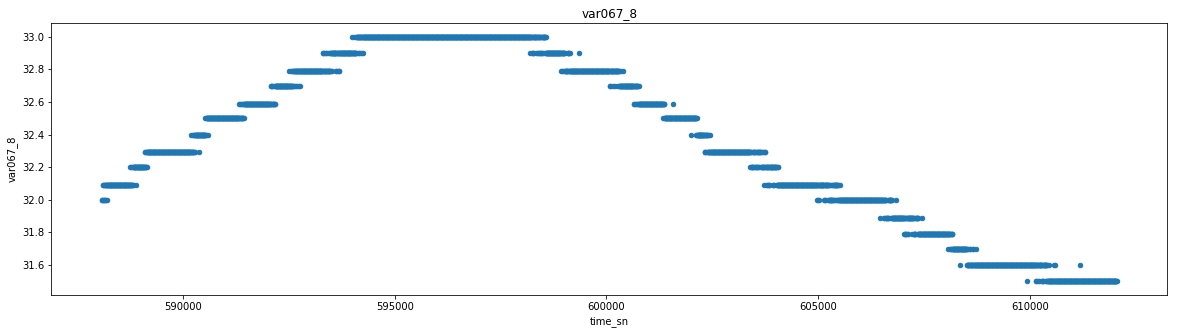

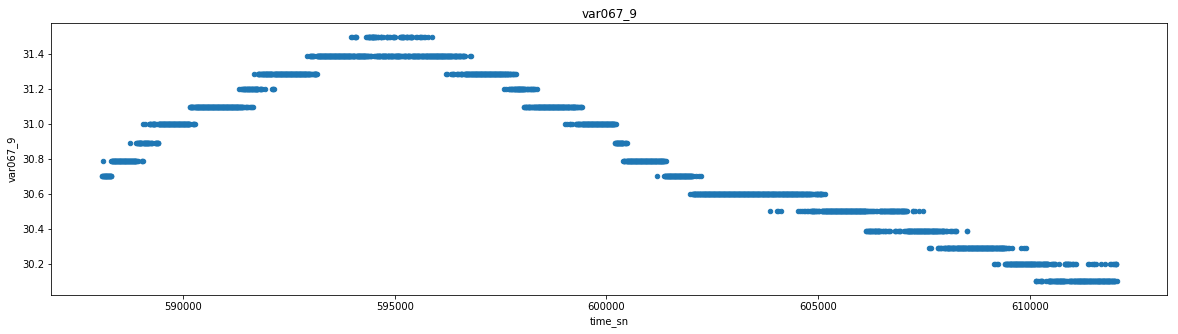

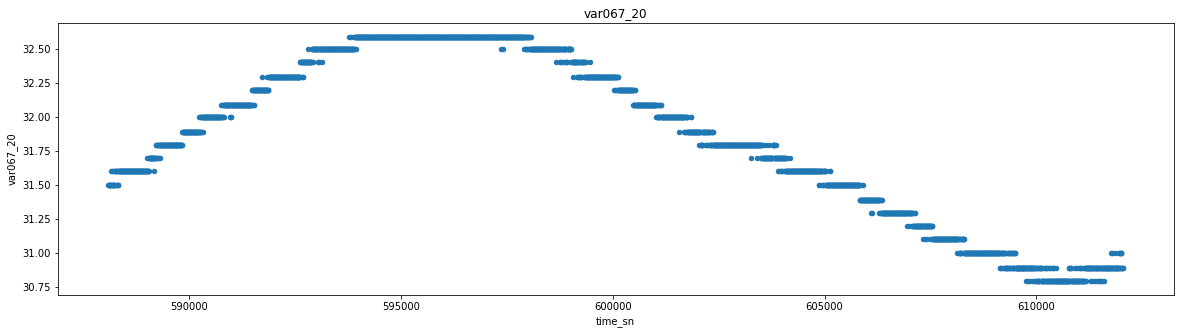

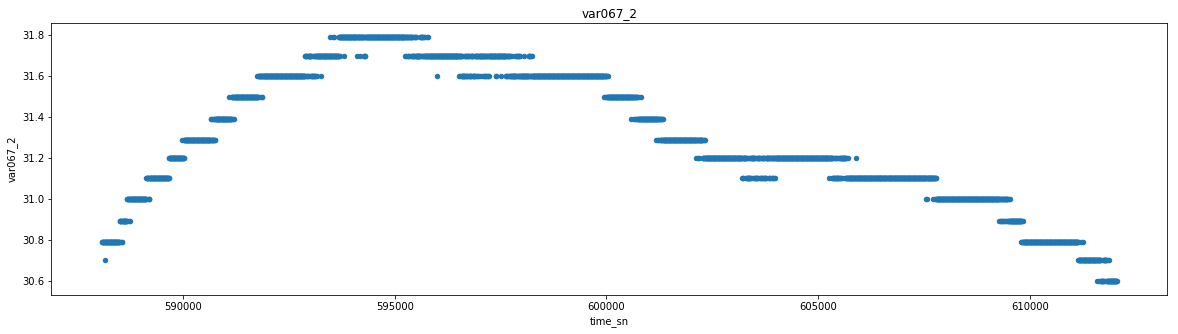

,var067,var067_8,var067_9,var067_20,var067_2,time_sn
id,,,,,,
79803,30.20,32.00,30.70,31.5,30.79,588089.575
79804,30.29,32.00,30.70,31.5,30.79,588096.943
79805,30.29,32.09,30.70,31.5,30.79,588104.307
79806,30.29,32.09,30.79,31.5,30.79,588111.678
79807,30.29,32.00,30.70,31.5,30.79,588119.043


In [22]:
#col_name = 'var067'
tmp = get_train_feature_multi_file(5, col_name, args.file_num)
print(tmp.columns)


begin, end  = 79803,83052
tmp_part = tmp.loc[begin:end, col_name]
#tmp_part.plot(figsize=(20,5))

print(tmp[begin:end].time_sn.min(), tmp[begin:end].time_sn.max())
for cur_col in [item for item in tmp.columns if  'var' in item]:
    tmp.loc[begin:end].plot.scatter(x='time_sn', y=cur_col,  figsize=(20,5), title=cur_col)


plot.show()

tmp.loc[begin:end].head()


In [ ]:
tmp = get_train_ex(5).loc[begin:end]
tmp.head()

In [ ]:
val = tmp.loc[begin:end]

s=score(val.var018.iloc[1:], val.var018.shift(1).iloc[1:])
s[1]/s[0]

 

In [ ]:
val.var018.shift(1)

In [ ]:
tmp = tmp.copy()
tmp['tmp'] = tmp.var031.shift(1)
#tmp['tmp'] = tmp.var031.rolling(2).mean().shift(1)
tmp = tmp[['var031', 'tmp']].dropna(how='any')

s=score(tmp.var031, tmp.tmp)
s[1]/s[0]


In [ ]:
get_blocks()

In [ ]:

print(cor.loc[f'{col_name}_1', f'{col_name}_2'])


step = 5000
begin = 4000 + step
end = 6000 +step



print(len(train_1.time_sn_1.loc[begin:end]) , len(train_2.time_sn_2.loc[begin:end]))

train_1[f'{col_name}_1'].loc[begin:end].plot()

train_2[f'{col_name}_2'].loc[begin:end].plot()

plt.show()

### 

In [ ]:
train_1.loc[begin:end]

In [ ]:
train_1.var034_1.iloc[begin:end].plot?

In [ ]:
train_1.var034_1.iloc[begin:end].plot

In [ ]:
tmp = std.groupby(['col', 'data_type'])['mean'].mean().sort_values().to_frame().reset_index()
print(tmp.columns)
tmp[tmp['data_type']=='int16']

In [ ]:
columns = list(date_type.keys())
columns.remove('wtid')
columns = sorted(columns)
for wtid in sorted(range(1, 34), reverse=True):
    for col in columns:
        check_std(wtid,col)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)


get_sub_template()

In [ ]:
get_blocks().iloc[45]

In [ ]:
get_blocks().iloc[6735]

In [ ]:

tmp = get_train_ex(3).loc[173119-4000:173119][['time_sn', 'var002']]
tmp.loc[(tmp.time_sn > 1250000) & (tmp.time_sn < 1290000)]

In [ ]:


feature_list = get_train_feature(1, 'var001')

len(feature_list)

In [ ]:
bk.groupby(['wtid','col']).length.sum()

In [ ]:
template = get_train_ex(1)
template.ts = pd.to_datetime(template.ts)
template['ts2'] = template.ts.shift(1)
template['gap'] = template.ts - template.ts2

template.gap = template['gap'].astype(int)//1000000000 
template['gap'].astype(int).hist()
plot.show()

In [ ]:
template['gap'].value_counts().sort_index()
#template['gap'].drop_duplicates().sort_values()

In [ ]:
 
        
col = 'var003'
get_result(1, col)


In [ ]:
train = get_train_ex(1)
train.iloc[354983-3: 354983+3]

In [ ]:

print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure(0)
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure(1)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure(2)
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()


In [ ]:
tmp['time_sn'] = (tmp.ts - pd.to_datetime('2018-07-01')).astype(int)/1000000000
 
# from datetime import timedelta
# tmp['gap'] = tmp['gap']/timedelta(hours=1)
# #tmp['gap'] = (  pd.to_datetime(tmp.ts2) - pd.to_datetime(tmp.ts) ) #/ np.timedelta64(1, 's')
# tmp.head()
#tmp.gap.astype(int)
tmp

In [ ]:
train = get_train_ex(1) 



missing = train[pd.isna(train['var001'])].index


In [ ]:
tmp.iloc[170590: 170599]

In [ ]:
tmp_1.var001.iloc[200:300].plot()
plot.show()

In [ ]:
tmp_1.var001.dropna().plot()
plot.show()

In [ ]:
len(tmp_1.var003), len(tmp_1.var003.dropna())

In [ ]:
from core.config import date_type
example = pd.read_csv('./input/submit_example.csv', dtype=date_type) 
example.head()


example.var016.drop_duplicates()


In [ ]:
pd.value_counts(example.var016)

In [ ]:
example.var001.iloc[0:3].astype(str)

In [ ]:
example.var001.iloc[0:3].apply(lambda val : True if val==405.37 else False)

In [ ]:
example.head()

In [ ]:
plt.show()

In [ ]:
from core import feature

In [ ]:

template = pd.read_csv('./input/template_submit_result.csv') 

print(template.shape)
#template 

In [ ]:

template = pd.read_csv('./input/template_submit_result.csv') 

train = pd.read_csv('./input/001/201807.csv') 
print(train.shape)

template = template.set_index(['ts', 'wtid'])
train = train.set_index(['ts', 'wtid'])


train = train[train.index.isin(template.index)]

train.shape

tmp = template.combine_first(train)
print(tmp.shape)


In [ ]:

 

tmp = get_sub_template()

tmp.head()

In [ ]:
tmp = get_sub_template()


In [ ]:
tmp.head(100)

In [ ]:
train_01 = pd.read_csv('./input/001/201807.csv') 
train_01.head()
#del train_01




In [ ]:
from core.feature import *
df = get_missing_analysis()

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
df.var001[:1].describe()

In [ ]:
df.var001.astype(int).std()

In [ ]:
np.finfo(np.float16).max

In [ ]:

def get_analysis_enum():
    col_list = ['wtid','var053','var066','var016','var020','var047',  ]

    train_list = []
    for wtid in range(1, 34):
        wtid = str(wtid)
        train = pd.read_csv(f"./input/{wtid.rjust(3,'0')}/201807.csv", usecols=col_list)
        train = train.groupby(col_list).agg({'wtid':'count'})
        train.rename(index=str, columns={"wtid": "count"}, inplace=True)
        train = train.reset_index()
        print(train.shape)
        train_list.append(train)

    all = pd.concat(train_list)
    return all

enum_type = get_analysis_enum()

In [ ]:
tmp = enum_type[['var053','var066','var016','var020','var047',]].drop_duplicates(['var053','var066','var016','var020','var047',])

In [ ]:
enum_type.sort_values(['wtid', 'count', ], ascending=False)

In [ ]:
for i in sorted((range(1, 34)),reverse=True):
    print(i)

In [ ]:
import pprint
pprint.pprint(abc)

pprint.PrettyPrinter?

In [ ]:
abc = {'a':'b', 'c':'d'}


In [ ]:
tmp = get_blocks()

In [ ]:
time_all = pd.DataFrame()
time_list = []
for i in range(1, 4):
    train = get_train_ex(i)
    print(len(train))
    time_list.append(train.ts)
    
time_all = pd.concat(time_list, axis=1)

In [ ]:
time_all['min'] = time_all.iloc[:,:-3].min(axis=1)
time_all['max'] = time_all.iloc[:,:-3].max(axis=1)
time_all['gap'] = time_all['max'] - time_all['min']
time_all['gap'] =  time_all['gap'].astype(int).fillna(0)//1000000000
time_all.head()